# Libraries

In [ ]:
# 3pps
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

# Functions

In [ ]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Class definition

In [2]:
class LeNet(nn.Module):

    def __init__(self, input_tensor: tuple[int, ...]) -> None:

        super().__init__()

        self.input_tensor = input_tensor

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=self.input_tensor[0], out_channels=16, kernel_size=4, stride=2, padding="valid"),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding="valid"),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten(),
            nn.Linear(32, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:

        return self.model(input_tensor)

# Main

In [3]:
batch_size=64

In [ ]:
model = LeNet(input_tensor=(1,28,28))
summary(model, input_size=(batch_size, 1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 16, 13, 13]          272
│    └─BatchNorm2d: 2-2                  [64, 16, 13, 13]          32
│    └─ReLU: 2-3                         [64, 16, 13, 13]          --
│    └─Conv2d: 2-4                       [64, 32, 5, 5]            8,224
│    └─BatchNorm2d: 2-5                  [64, 32, 5, 5]            64
│    └─ReLU: 2-6                         [64, 32, 5, 5]            --
│    └─AdaptiveAvgPool2d: 2-7            [64, 32, 1, 1]            --
│    └─Flatten: 2-8                      [64, 32]                  --
│    └─Linear: 2-9                       [64, 10]                  330
│    └─Softmax: 2-10                     [64, 10]                  --
Total params: 8,922
Trainable params: 8,922
Non-trainable params: 0
Total mult-a

In [5]:
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Load the test dataset
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create data loader for the training dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create data loader for the test dataset
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

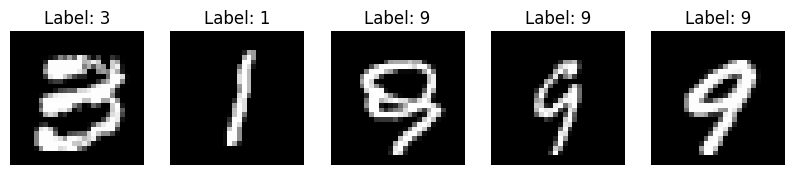

In [ ]:
# Get a batch of images from the training data loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 5 images
show_images(images[:5], labels[:5])

In [9]:
images.shape

torch.Size([64, 1, 28, 28])

In [10]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [11]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

In [13]:
num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    loss_epoch = 0
    correct = 0
    total = 0

    model.train()
    for batch_image, batch_label in train_loader:
        # Ponemos a 0 los gradientes
        optimizer.zero_grad()

        # Forward
        output = model(batch_image)
        _, predicted = torch.max(output, 1)
        total += batch_label.size(0)
        correct += (predicted == batch_label).sum().item()

        # Loss
        loss = loss_function(output, batch_label)

        # Backward + Optimización
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    # Resultados de la época
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {loss_epoch / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct_test / total_test:.2f}%')

 20%|██        | 1/5 [00:15<01:00, 15.20s/it]

Epoch 1, Loss: 1.9959, Accuracy: 53.37%


 40%|████      | 2/5 [00:28<00:42, 14.16s/it]

Epoch 2, Loss: 1.6674, Accuracy: 88.42%


 60%|██████    | 3/5 [00:41<00:27, 13.68s/it]

Epoch 3, Loss: 1.5781, Accuracy: 93.00%


 80%|████████  | 4/5 [00:56<00:14, 14.28s/it]

Epoch 4, Loss: 1.5481, Accuracy: 94.57%


100%|██████████| 5/5 [01:10<00:00, 14.10s/it]

Epoch 5, Loss: 1.5322, Accuracy: 95.45%


Accuracy on test set: 95.76%


In [15]:
image = np.asarray(Image.open("example.png"))
image.shape

(1480, 1490)

In [16]:
image_tensor = torch.from_numpy(np.expand_dims(image, axis=[0,1]))
image_tensor.shape

/var/folders/qv/4cwcqgqn0yg_rfr41_mcxgt80000gn/T/ipykernel_5400/2622785412.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  image_tensor = torch.from_numpy(np.expand_dims(image, axis=[0,1]))


torch.Size([1, 1, 1480, 1490])

In [18]:
image_tensor_resized = torchvision.transforms.Resize(size=(28, 28))(image_tensor)
image_tensor_resized.shape

torch.Size([1, 1, 28, 28])

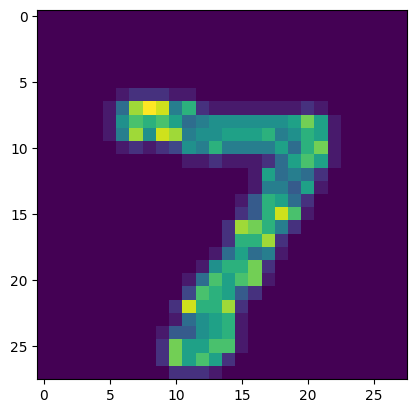

In [19]:
plt.imshow(image_tensor_resized[0,0,:,:])

In [20]:
image_tensor_resized.min(), image_tensor_resized.max()

(tensor(0, dtype=torch.uint8), tensor(14, dtype=torch.uint8))

In [21]:
image_tensor_resized = image_tensor_resized * 255
image_tensor_resized = image_tensor_resized *  1/255
image_tensor_resized.min(), image_tensor_resized.max()

(tensor(0.), tensor(1.))

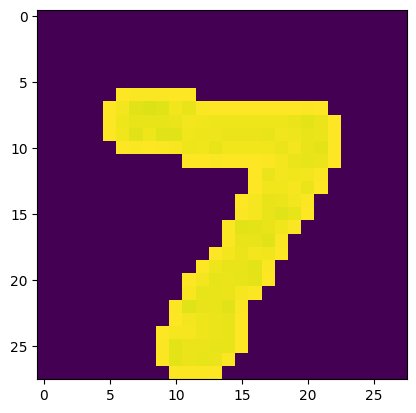

In [22]:
plt.imshow(image_tensor_resized[0,0,:,:], vmin=0, vmax=1)

In [29]:
model.eval()
with torch.no_grad():
    prediction_img = model(image_tensor_resized)

len(prediction_img[0])

10

In [32]:
prediction_img[0].max(), prediction_img[0].argmax()

(tensor(0.9990), tensor(7))

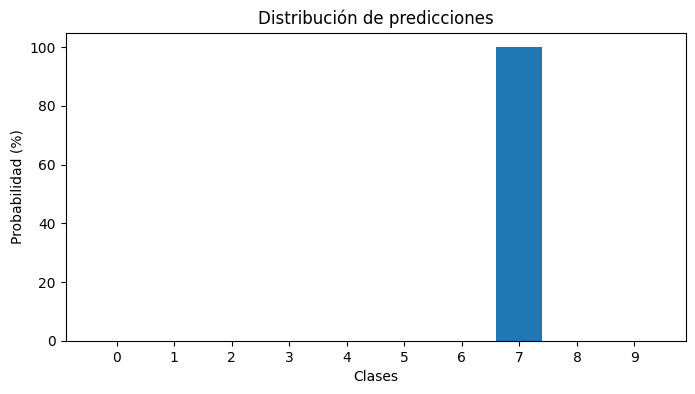

In [34]:
# Convertir a numpy
prediction_img = prediction_img.numpy()[0]  # array de tamaño 10

# Clases
classes = list(range(10))

# Gráfico de barras
plt.figure(figsize=(8,4))
plt.bar(classes, prediction_img*100)  # multiplicamos por 100 para %
plt.xticks(classes)
plt.xlabel("Clases")
plt.ylabel("Probabilidad (%)")
plt.title("Distribución de predicciones")
plt.show()